In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy

from datetime import datetime
from collections import Counter, defaultdict

from scipy.stats import norm, normaltest, percentileofscore

import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from tqdm.notebook import tqdm

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io, filters, constants
from analysis import analysis_util, analysis_constants, visualization_util
from web_analysis import parse_robots
from web_analysis import robots_util, forecasting_util

%load_ext autoreload
%autoreload 2

In [2]:
os.chdir(os.path.expanduser('~/github/Data-Provenance-Collection/'))

In [3]:
def times_newroman():
    font = "Times New Roman"

    return {
          "config" : {
               "title": {"font": font},
               "axis": {
               "labelFont": font,
               "titleFont": font
          },
          "header": {
               "labelFont": font,
               "titleFont": font
          },
          "legend": {
               "labelFont": font,
               "titleFont": font
          },
          "text": {
               "font": font
          }
     }
}

alt.themes.register("times_newroman", times_newroman)
alt.themes.enable("times_newroman")

ThemeRegistry.enable('times_newroman')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Define Paths to all relevant files

In [5]:
FPATH_TO_RELEVANT_URL_TOKENS = 'src/analysis/pretrain_data/relevant_url_token_counts.csv'
FPATH_to_HEAD_ROBOTS = "plot-stuff/temporal_robots_head.json"
FPATH_TO_RAND_ROBOTS = "plot-stuff/temporal_robots_rand_10k.json"
FPATH_TO_TOS_DATA = "plot-stuff/tos_ai_scraping_policies.json"
FPATH_TO_TOS_COMPETE_DATA = "plot-stuff/tos_competing_services_policies.json"
FPATH_TO_TOS_LICENSE_DATA = "plot-stuff/tos_license_policies.json"
DIRPATHS_TO_ANNOTATED_TASKS = ["plot-stuff/task-1", "plot-stuff/task-2"]
START_DATES = "plot-stuff/domain_start_dates.json"

ALL_COMPANIES_TO_TRACK = ["Google", "OpenAI", "Anthropic", "Cohere", "Meta", "Common Crawl", "Internet Archive", "Google Search", "False Anthropic"]
COMPANIES_TO_ANALYZE = ["Google", "OpenAI", "Anthropic", "Cohere", "Common Crawl", "Meta"]
TEMPORAL_ANALYSIS_START_DATE = '2016-01-01'
TEMPORAL_ANALYSIS_END_DATE = '2024-04-30'

### Load all URL splits (top vs random) and maps to Token Counts

In [6]:
url_token_lookup = robots_util.URLTokenLookup(FPATH_TO_RELEVANT_URL_TOKENS) # 'c4', 'rf', 'dolma'
c4_url_to_counts = url_token_lookup.get_url_to_token_map("c4")
rf_url_to_counts = url_token_lookup.get_url_to_token_map("rf")
dolma_url_to_counts = url_token_lookup.get_url_to_token_map("dolma")
top_c4_urls = url_token_lookup.top_k_urls("c4", 2000)
top_rf_urls = url_token_lookup.top_k_urls("rf", 2000)
top_dolma_urls = url_token_lookup.top_k_urls("dolma", 2000)
random_10k_urls = url_token_lookup.get_10k_random_sample()
all_urls = set(random_10k_urls + top_c4_urls + top_rf_urls + top_dolma_urls)

# Load website snapshots for relevant URLs
website_start_dates = robots_util.read_start_dates(START_DATES, all_urls) # THIS WON'T WORK FOR THE 10k SAMPLE

Number of tokens in 2000 URLs: 18447797380 | 10.85% of c4
Number of tokens in 2000 URLs: 67098747294 | 15.56% of rf
Number of tokens in 2000 URLs: 429152555144 | 21.74% of dolma


### Define Agents and Agent Groups

In [7]:
agent_groups_to_track = robots_util.get_bot_groups(ALL_COMPANIES_TO_TRACK)
agents_to_track = robots_util.get_bots()

### Load Robots.txt info

In [8]:
# URL -> Date -> Robots.txt raw text
head_robots = io.read_json(FPATH_to_HEAD_ROBOTS)
random_10k_robots = io.read_json(FPATH_TO_RAND_ROBOTS)
joined_robots = copy.deepcopy(head_robots)
joined_robots.update(random_10k_robots)
robots_util.print_out_robots_info(head_robots)
robots_util.print_out_robots_info(random_10k_robots)

# {URL --> Date --> Agent --> Status}
url_robots_summary, agent_counter_df = robots_util.compute_url_date_agent_status(
    data=joined_robots, 
    # relevant_agents=agents_to_track)
    relevant_agents=[v for vs in agent_groups_to_track.values() for v in vs])

agent_counter_df.to_csv("src/analysis/all_agents_counter.csv", index=False)

Num robot URLs loaded: 2985
Earliest time: 2016-01-01
Last time: 2024-04-19
Num robot URLs loaded: 6331
Earliest time: 2016-01-01
Last time: 2024-04-19


In [9]:
url_robots_summary_detailed = robots_util.compute_url_date_agent_status_detailed(
    data=joined_robots, 
    relevant_agents=[v for vs in agent_groups_to_track.values() for v in vs]
)

In [10]:
# url_robots_summary_detailed[list(url_robots_summary_detailed.keys())[0]]

### Load ToS info

In [11]:
# URL --> Date --> ToS-suburl --> {"verdict": X, "evidence": Y}
tos_policies = io.read_json(FPATH_TO_TOS_DATA)
tos_license_policies = io.read_json(FPATH_TO_TOS_LICENSE_DATA)
tos_compete_policies = io.read_json(FPATH_TO_TOS_COMPETE_DATA)
# tos_license_policies = robots_util.switch_dates_yearly_to_monthly(tos_license_policies)
print(f"Num ToS AI/Scraping URLs: {len(tos_policies)}")
print(f"Num ToS License URLs: {len(tos_license_policies)}")
print(f"Num ToS Compete URLs: {len(tos_compete_policies)}")

Num ToS AI/Scraping URLs: 3068
Num ToS License URLs: 3070
Num ToS Compete URLs: 3070


### Load Manual Pretraining Annotations

In [12]:
url_to_info = analysis_util.extract_url_annotations(DIRPATHS_TO_ANNOTATED_TASKS)
url_results_df = analysis_util.process_url_annotations(url_to_info)
url_results_df = analysis_util.encode_size_columns(url_results_df, url_token_lookup)
url_results_df = robots_util.encode_latest_tos_robots_into_df(
    url_results_df, tos_policies, tos_license_policies, tos_compete_policies, url_robots_summary,
    COMPANIES_TO_ANALYZE
)

assert url_results_df['URL'].nunique() == url_results_df.shape[0]

6664 rows before filtering.
4026 rows after filtering. 1580 issues, 1058 unannotated.
<class 'collections.defaultdict'>
9312


### DECISION POINT: Use C4, Dolma, or RefinedWeb here?

In [13]:
CHOSEN_CORPUS = "dolma" # 'c4', 'rf', 'dolma'
if CHOSEN_CORPUS == "c4":
    HEAD_URL_SET = top_c4_urls
    URL_TO_COUNTS = c4_url_to_counts
elif CHOSEN_CORPUS == "rf":
    HEAD_URL_SET = top_rf_urls
    URL_TO_COUNTS = rf_url_to_counts
elif CHOSEN_CORPUS == "dolma":
    HEAD_URL_SET = top_dolma_urls
    URL_TO_COUNTS = dolma_url_to_counts

In [14]:
url_robots_summary_head = {url: url_robots_summary[url] for url in HEAD_URL_SET if url in url_robots_summary}
url_robots_summary_head_detailed = {url: url_robots_summary_detailed[url] for url in HEAD_URL_SET if url in url_robots_summary_detailed}
url_robots_summary_rand = {url: url_robots_summary[url] for url in random_10k_urls if url in url_robots_summary}

# Data for Ariel

In [15]:
# url_robots_summary_rand_detailed = {url: url_robots_summary_detailed[url] for url in random_10k_urls if url in url_robots_summary_detailed}

In [16]:
# detailed_strictness_order = [
#     'no_robots', 'none', 'none_sitemap', 'none_crawl_delay', 'some_pattern_restrictions', 'some_disallow_important_dir', 'some_other', 'all'
# ]

In [17]:
# robots_filled_status_rand_summary_detailed = robots_util.prepare_robots_temporal_summary_detailed(
#     url_robots_summary=url_robots_summary_rand_detailed,
#     group_to_agents=agent_groups_to_track,
#     start_time=TEMPORAL_ANALYSIS_START_DATE,
#     end_time=TEMPORAL_ANALYSIS_END_DATE,
#     time_frequency="M",
#     website_start_dates=website_start_dates,
# )

In [18]:
# robots_temporal_rand_summary_detailed = robots_util.robots_temporal_to_df(
#     robots_filled_status_rand_summary_detailed,
#     strictness_order=detailed_strictness_order,
#     url_to_counts=URL_TO_COUNTS,
# )

In [19]:
# robots_filled_status_head_summary_detailed = robots_util.prepare_robots_temporal_summary_detailed(
#     url_robots_summary=url_robots_summary_head_detailed,
#     group_to_agents=agent_groups_to_track,
#     start_time=TEMPORAL_ANALYSIS_START_DATE,
#     end_time=TEMPORAL_ANALYSIS_END_DATE,
#     time_frequency="M",
#     website_start_dates=website_start_dates,
# )

In [20]:
# robots_temporal_head_summary_detailed = robots_util.robots_temporal_to_df(
#     robots_filled_status_head_summary_detailed,
#     strictness_order=detailed_strictness_order,
#     url_to_counts=URL_TO_COUNTS,
# )

In [21]:
# statuses_to_include = ['all', 'some_pattern_restrictions', 'some_disallow_important_dir']

# rand_restricted = robots_temporal_rand_summary_detailed \
#     .loc[robots_temporal_rand_summary_detailed['agent'] == 'Combined Agent'] \
#     .loc[robots_temporal_rand_summary_detailed['status'].isin(statuses_to_include)] \
#     [['period', 'tokens']]
# rand_restricted = rand_restricted.groupby('period').sum()['tokens']

# rand_all = robots_temporal_rand_summary_detailed \
#     .loc[robots_temporal_rand_summary_detailed['agent'] == 'Combined Agent'] \
#     [['period', 'tokens']]
# rand_all = rand_all.groupby('period').sum()['tokens']

# head_restricted = robots_temporal_head_summary_detailed \
#     .loc[robots_temporal_head_summary_detailed['agent'] == 'Combined Agent'] \
#     .loc[robots_temporal_head_summary_detailed['status'].isin(statuses_to_include)] \
#     [['period', 'tokens']]
# head_restricted = head_restricted.groupby('period').sum()['tokens']

# head_all = robots_temporal_head_summary_detailed \
#     .loc[robots_temporal_head_summary_detailed['agent'] == 'Combined Agent'] \
#     [['period', 'tokens']]
# head_all = head_all.groupby('period').sum()['tokens']

# assert (rand_restricted.index == head_restricted.index).all()
# assert (rand_all.index == head_all.index).all()
# assert (rand_restricted.index == head_all.index).all()
# assert rand_restricted.index.is_unique
# assert head_restricted.index.is_unique
# assert rand_all.index.is_unique
# assert head_all.index.is_unique

# total_tokens = url_token_lookup._TOTAL_TOKENS[CHOSEN_CORPUS]
# top_corpus_urls = url_token_lookup.top_k_urls(CHOSEN_CORPUS, 2000)
# corpus_urls_to_counts = url_token_lookup.get_url_to_token_map(CHOSEN_CORPUS)
# num_head_tokens = sum([v for k, v in corpus_urls_to_counts.items() if k in top_corpus_urls])
# non_head_tokens = total_tokens - num_head_tokens

# assert non_head_tokens >= 0

# out = pd.concat([
#     (non_head_tokens * (rand_restricted / rand_all) / total_tokens).rename('rand'),
#     (num_head_tokens * (head_restricted / head_all) / total_tokens).rename('head'),
# ], axis=1)

# out.to_csv(f'src/analysis/{CHOSEN_CORPUS}_total_token_estimates.csv', index=True)

# Table

In [22]:
from sklearn.linear_model import LogisticRegression

ALL_VARS = [
    'User Content', 'Paywall', 'Ads','Modality: Image', 'Modality: Video', 'Modality: Audio',
    'Sensitive Content', 'services_Academic', 'services_Blogs',
    'services_E-Commerce', 'services_Encyclopedia/Database',
    'services_Government', 'services_News/Periodicals',
    'services_Organization/Personal Website', 'services_Other',
    'services_Social Media/Forums', 'Restrictive Robots.txt', 'Restrictive Terms'
]

def run_population_analysis(
    url_results_df, 
    url_token_lookup,
    top_corpus_urls, 
    corpus_name,
):
    data_head = url_results_df \
        .loc[url_results_df['URL'].isin(top_corpus_urls)] \
        .rename({f"{corpus_name} tokens": 'magnitude'}, axis=1) \
        [ALL_VARS + ['magnitude', 'URL']] \
        .set_index('URL') \
        .astype(int)
    
    data_random = url_results_df \
        .loc[url_results_df['sample'] == 'random'] \
        .rename({f"{corpus_name} tokens": 'magnitude'}, axis=1) \
        [ALL_VARS + ['magnitude', 'URL']] \
        .set_index('URL') \
        .astype(int)

    total_urls = url_token_lookup._TOTAL_URLS[corpus_name]
    total_tokens = url_token_lookup._TOTAL_TOKENS[corpus_name]
    total_urls_rest = total_urls - data_head.shape[0] - data_random.shape[0]
    total_tokens_rest = total_tokens - data_head['magnitude'].sum() - data_random['magnitude'].sum()

    final_results = {}
    for bvar in ALL_VARS:
        pred_rest = data_random[bvar].mean()
    
        est_urls = data_head[bvar].sum() + data_random[bvar].sum() + (pred_rest * total_urls_rest).sum()
        est_tokens = (
            (data_head['magnitude'] * data_head[bvar]).sum() +
            (data_random['magnitude'] * data_random[bvar]).sum() +
            (pred_rest * total_tokens_rest).sum()  # FIXME
        )
    
        final_results[bvar] = {
            'est_url_pct': est_urls / total_urls,
            'est_tokens_pct': est_tokens / total_tokens,
        }
    
    return pd.DataFrame(final_results).T

def analyze_url_variable_correlations(df, top_n_list=[100, 500, 2000]):
    ret = {}
    for top_n in top_n_list:
        top_n_c4_df = df.loc[df['c4 rank'] <= top_n]
        top_n_rf_df = df.loc[df['rf rank'] <= top_n]
        top_n_dolma_df = df.loc[df['dolma rank'] <= top_n]

        ret[f'Top {top_n}'] = (
            top_n_c4_df[ALL_VARS].mean() +
            top_n_rf_df[ALL_VARS].mean() +
            top_n_dolma_df[ALL_VARS].mean()
        ) / 3
    
    ret['Random'] = df.loc[df['sample'] == 'random', ALL_VARS].mean()

    return pd.DataFrame(ret)

def url_variable_instance(url_token_lookup, url_results_df, n_resamples=100000, n_pa_resamples=200):
    url_correlation_df = analyze_url_variable_correlations(url_results_df)

    if n_resamples is not None and n_resamples > 0:
        tmp = url_results_df.copy().set_index('URL')
        keys = tmp.loc[tmp['sample'] == 'random'].index.unique().tolist()
        
        resamples = {}
        for i in tqdm(range(n_resamples)):
            domains = np.random.choice(keys, len(keys), replace=True)
            resamples[i] = tmp.loc[domains, ALL_VARS].mean()
        resamples = pd.DataFrame(resamples)

    def pop_analysis(df, domains=None):
        if domains is not None:
            c4_domains, rf_domains, dolma_domains = domains, domains, domains
        else:
            c4_domains = url_token_lookup.top_k_urls('c4', 2000)
            rf_domains = url_token_lookup.top_k_urls('rf', 2000)
            dolma_domains = url_token_lookup.top_k_urls('dolma', 2000)
        
        return {
            'C4': run_population_analysis(
                df,
                url_token_lookup,
                c4_domains,
                'c4',
            )['est_tokens_pct'],
            
            'RW': run_population_analysis(
                df, 
                url_token_lookup,
                rf_domains,
                'rf',
            )['est_tokens_pct'],
            
            'Dolma': run_population_analysis(
                df, 
                url_token_lookup,
                dolma_domains,
                'dolma',
            )['est_tokens_pct']
        }

    pct_tokens_in_corpus = pop_analysis(url_results_df)
    url_correlation_df['C4'] = pct_tokens_in_corpus['C4']
    url_correlation_df['RW'] = pct_tokens_in_corpus['RW']
    url_correlation_df['Dolma'] = pct_tokens_in_corpus['Dolma']

    pct_resamples = []
    for i in tqdm(range(n_pa_resamples)):
        tmp = url_results_df.copy().set_index('URL')
        tmp = tmp.loc[tmp['sample'] == 'random']
        
        keys = tmp.index.unique().tolist()
        domains = np.random.choice(keys, len(keys), replace=True)
        tmp = tmp.loc[domains].reset_index()
        
        try:
            pct_resamples += [pd.DataFrame(pop_analysis(tmp, domains)).T.reset_index().rename({'index': 'corpus'}, axis=1).assign(i=i)]
        except ValueError:  # <2 classes for LogisticRegression
            continue
    pct_resamples = pd.concat(pct_resamples).set_index(['i', 'corpus'])
    
    url_correlation_df.columns = pd.MultiIndex.from_tuples([
        ('URL Group', 'Top 100'),
        ('URL Group', 'Top 500'),
        ('URL Group', 'Top 2000'),
        ('URL Group', 'Random'),
        ('Pct. Tokens in Corpus', 'C4'),
        ('Pct. Tokens in Corpus', 'RW'),
        ('Pct. Tokens in Corpus', 'Dolma'),
    ])
    
    url_correlation_df[('Stats', 'Diff')] = url_correlation_df[('URL Group', 'Top 2000')] - url_correlation_df[('URL Group', 'Random')]
    
    url_correlation_df = url_correlation_df[[
        ('URL Group', 'Top 100'),
        ('URL Group', 'Top 500'),
        ('URL Group', 'Top 2000'),
        ('URL Group', 'Random'),
        ('Stats', 'Diff'),
        ('Pct. Tokens in Corpus', 'C4'),
        ('Pct. Tokens in Corpus', 'RW'),
        ('Pct. Tokens in Corpus', 'Dolma'),
    ]]
    
    url_correlation_df.index = url_correlation_df.index.str.replace('services_', '')
    url_correlation_df.index.name = 'Variable'

    resamples.index = resamples.index.str.replace('services_', '')
    resamples.index.name = 'Variable'

    pct_resamples = pct_resamples.reset_index().drop('i', axis=1).groupby('corpus').std().T
    pct_resamples.index.name = 'Variable'
    pct_resamples.columns = pd.MultiIndex.from_tuples([('Pct. Tokens in Corpus', c) for c in pct_resamples.columns])
    pct_resamples.index = pct_resamples.index.str.replace('services_', '')
    
    return url_correlation_df, resamples, pct_resamples

In [23]:
url_correlation_df, url_correlation_resamples, url_correlation_pct_resamples = url_variable_instance(url_token_lookup, url_results_df)

  0%|          | 0/100000 [00:00<?, ?it/s]

Number of tokens in 2000 URLs: 18447797380 | 10.85% of c4
Number of tokens in 2000 URLs: 67098747294 | 15.56% of rf
Number of tokens in 2000 URLs: 429152555144 | 21.74% of dolma


  0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
## Sanity-check the resampling results

url_correlation_resamples.T.describe().T

,count,mean,std,min,25%,50%,75%,max
Variable,,,,,,,,
User Content,100000.000,0.151,0.010,0.110,0.144,0.151,0.157,0.194
Paywall,100000.000,0.016,0.003,0.003,0.014,0.016,0.019,0.034
Ads,100000.000,0.054,0.006,0.031,0.049,0.054,0.057,0.082
Modality: Image,100000.000,0.950,0.006,0.922,0.946,0.950,0.954,0.972
Modality: Video,100000.000,0.189,0.011,0.140,0.181,0.189,0.196,0.232
Modality: Audio,100000.000,0.034,0.005,0.013,0.031,0.034,0.037,0.057
Sensitive Content,100000.000,0.006,0.002,0.000,0.004,0.006,0.007,0.018
Academic,100000.000,0.038,0.005,0.018,0.034,0.038,0.042,0.063
Blogs,100000.000,0.151,0.010,0.108,0.145,0.151,0.158,0.197


In [25]:
# These will usually fail, but it's fine -- exact normality will generally
# not happen for large n, the histograms look good and show that there's
# nothing wrong with the resampling process
url_correlation_resamples.apply(lambda s: normaltest(s).pvalue, axis=1)

Variable
User Content                    0.000
Paywall                         0.000
Ads                             0.000
Modality: Image                 0.000
Modality: Video                 0.000
Modality: Audio                 0.000
Sensitive Content               0.000
Academic                        0.000
Blogs                           0.000
E-Commerce                      0.000
Encyclopedia/Database           0.000
Government                      0.000
News/Periodicals                0.000
Organization/Personal Website   0.041
Other                           0.000
Social Media/Forums             0.000
Restrictive Robots.txt          0.000
Restrictive Terms               0.000
dtype: float64

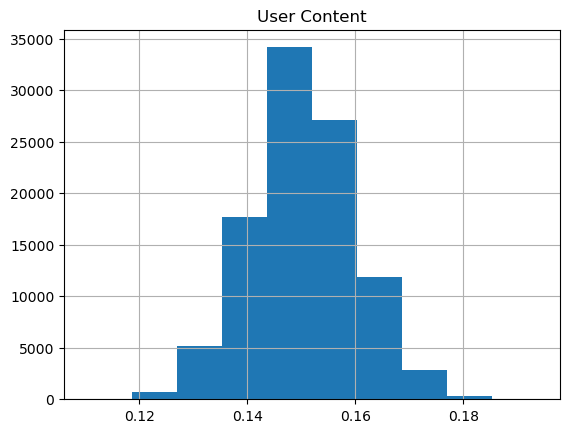

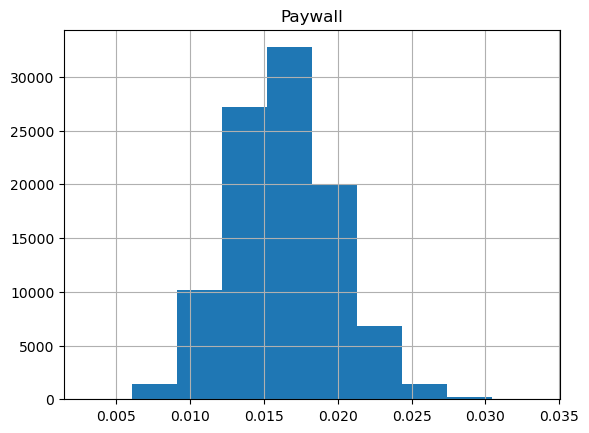

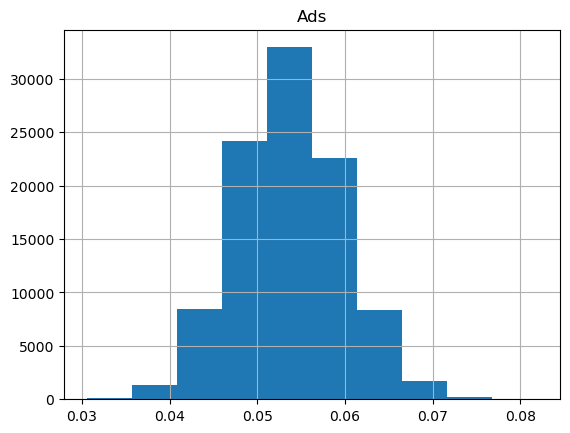

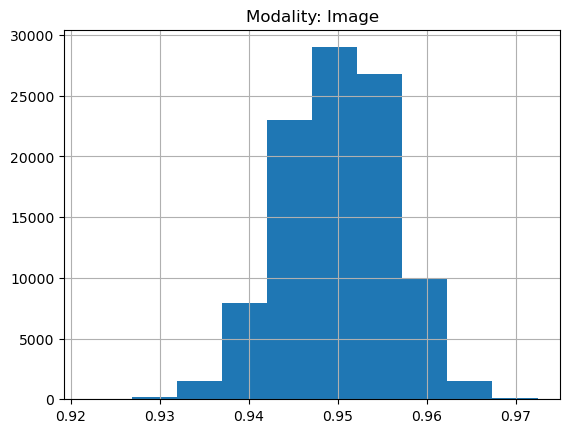

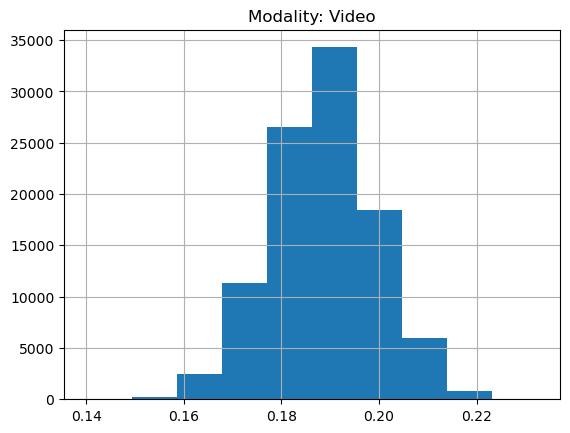

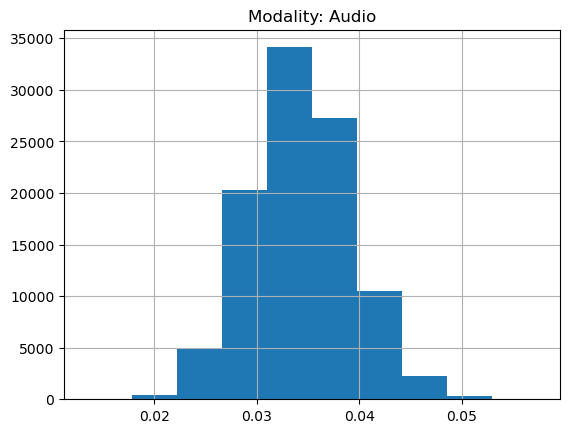

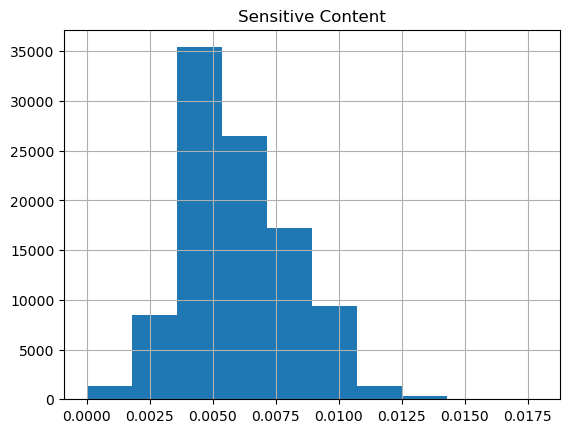

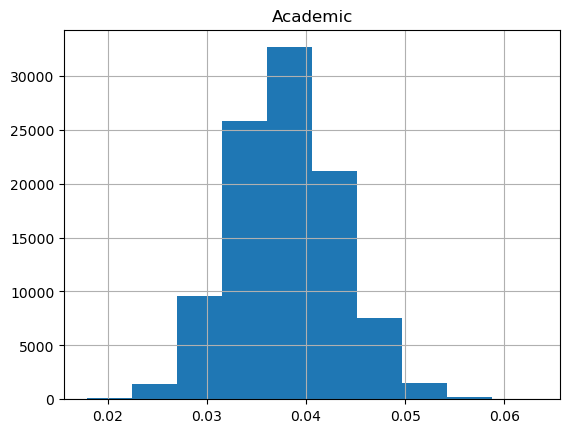

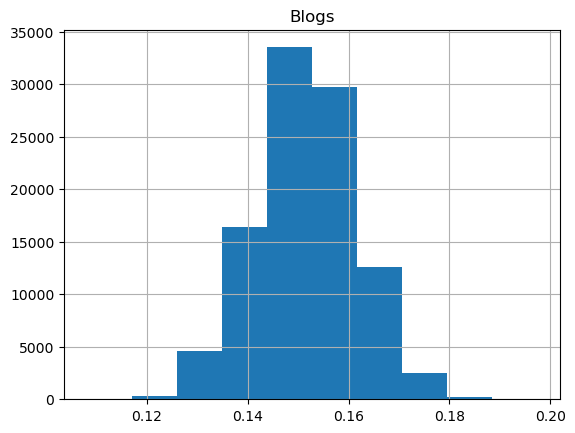

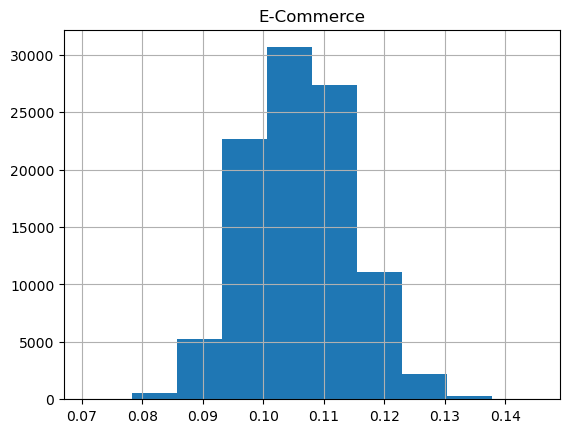

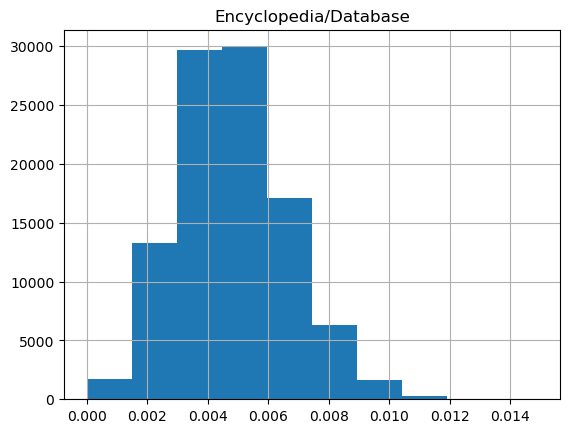

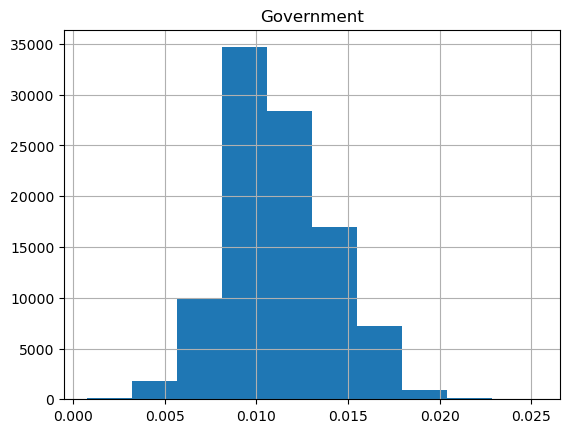

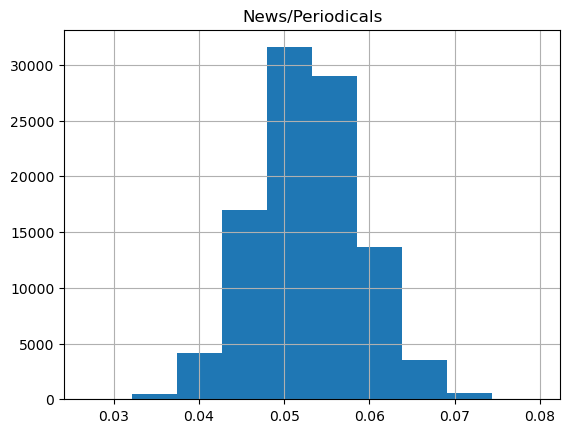

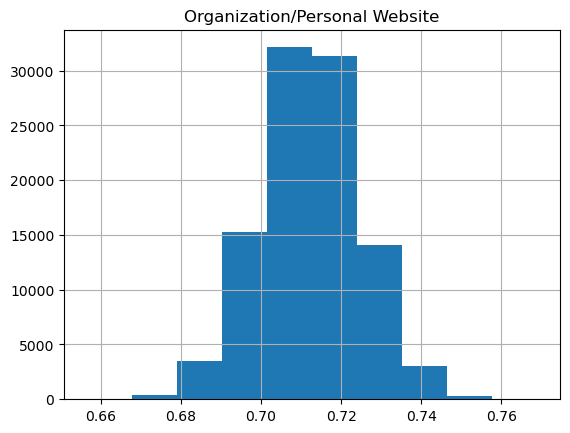

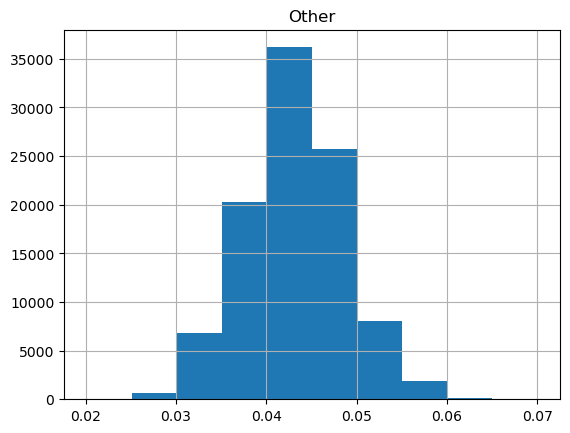

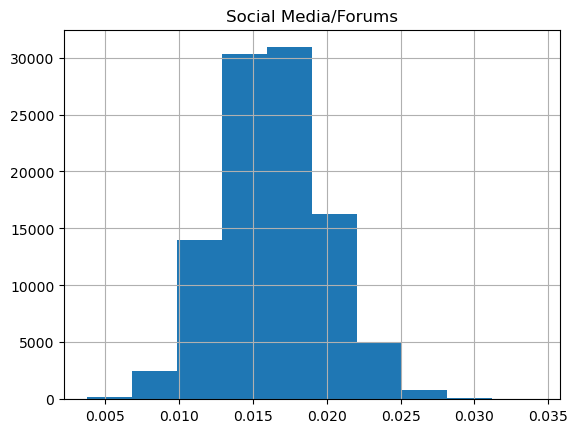

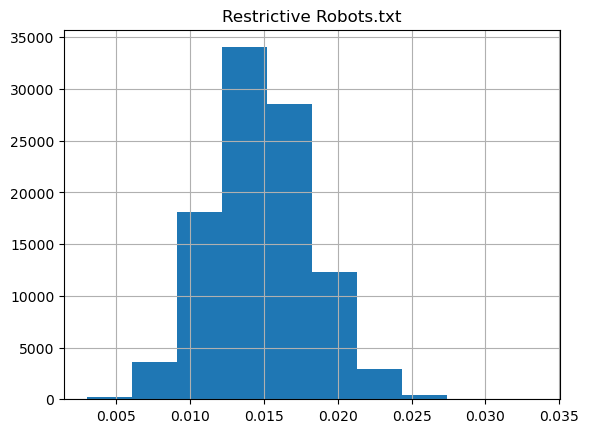

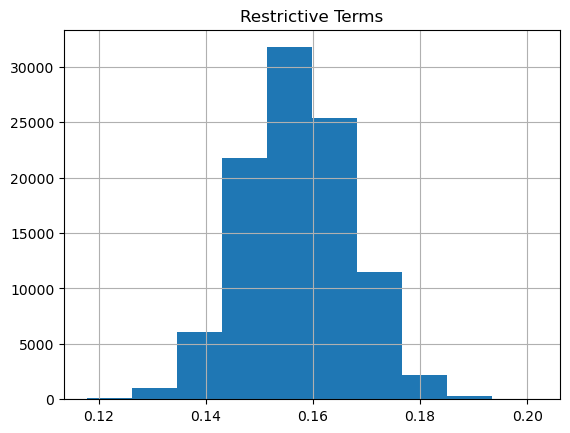

In [26]:
for i in url_correlation_resamples.index:
    fig, ax = plt.subplots()
    url_correlation_resamples.loc[i].hist(ax=ax)
    ax.set_title(i)

In [27]:
def run_tests(point, boot, alpha=None):
    if alpha is None:
        alpha = norm.sf(5) / (3 * point.shape[0]) # 5 sigma level

    tests = []
    for i in point.index:
        upper = boot.loc[i].quantile(1 - alpha / 2)
        lower = boot.loc[i].quantile(alpha / 2)
        
        for col in ['Top 100', 'Top 500', 'Top 2000']:
            observed = point.loc[i, ('URL Group', col)]
            
            tests += [{
                'var': i,
                'col': col,
                'observed': observed,
                'upper': upper,
                'lower': lower,
                'reject': (observed > upper or observed < lower),
            }]
    
    return pd.DataFrame(tests).set_index(['var', 'col'])

tests = run_tests(url_correlation_df, url_correlation_resamples)
tests_05 = run_tests(url_correlation_df, url_correlation_resamples, alpha=0.05)

(
    tests['reject'].sum() / tests.shape[0],
    tests_05['reject'].sum() / tests_05.shape[0],
)

(0.8148148148148148, 0.9259259259259259)

In [28]:
kwargs = {
    'environment': 'table',
    
    'label': 'tab:correlations',
    'column_format': 'l' + 'r' * url_correlation_df.shape[1],
    'multicol_align': 'c',
    
    'caption': (r'''
    \textbf{Mean incidence rates of web source features across C4, RefinedWeb, and Dolma.} We measure incidence rates for the top 100, 500, and 2000 URLs, ranked by number of tokens, as well as the random sample. The `Diff' column reports the \% difference between the top 2k and random samples. We test for significant differences between the overall corpus and each of the top-100, top-500 and top-2000 sets with a Bonferroni-corrected two-sided permutation test, where differences significant at the Bonferroni-corrected $5 \sigma$ level are indicated in bold. 81\% of differences are significant at this level, while 93\% are significant at the less strict $p = 0.05$ level. We also estimate the percentage of tokens in each corpus, C4, RefinedWeb, and Dolma, for which the web feature is present (\pm 95\% bootstrap CI shown in gray).
    '''.strip(), r'\textbf{Mean incidence rates of web source features across C4, RefinedWeb, and Dolma.}'),
    
    'hrules': True,
    'convert_css': True,
}

def color_values(val):
    color = 'red' if val < 0 else 'green' if val > 0 else 'black'
    return f'background-color: {color}'

def bold_rejects(column):
    def style_cell(cell_value, index, column_name):
        if column_name[0] != 'URL Group':
            return ''
        elif column_name[1] not in ('Top 100', 'Top 500', 'Top 2000'):
            return ''
        else:
            reject = tests.loc[(index, column_name[1]), 'reject']
            if reject:
                return 'font-weight: bold;'
            else:
                return ''

    return [style_cell(cell, idx, column.name) for cell, idx in zip(column, column.index)]

z = norm.ppf(1 - 0.05 / 2)
tmp = url_correlation_df.copy()
tmp[('Pct. Tokens in Corpus', 'C4')] = tmp[('Pct. Tokens in Corpus', 'C4')].apply(lambda s: '{:.1f}'.format(100*s)) + r'\scriptsize{\color{gray} \textpm ' + (z*url_correlation_pct_resamples[('Pct. Tokens in Corpus', 'C4')]).apply(lambda s: '{:.1f}'.format(100*s)) + '}'
tmp[('Pct. Tokens in Corpus', 'RW')] = tmp[('Pct. Tokens in Corpus', 'RW')].apply(lambda s: '{:.1f}'.format(100*s)) + r'\scriptsize{\color{gray} \textpm ' + (z*url_correlation_pct_resamples[('Pct. Tokens in Corpus', 'RW')]).apply(lambda s: '{:.1f}'.format(100*s)) + '}'
tmp[('Pct. Tokens in Corpus', 'Dolma')] = tmp[('Pct. Tokens in Corpus', 'Dolma')].apply(lambda s: '{:.1f}'.format(100*s)) + r'\scriptsize{\color{gray} \textpm ' + (z*url_correlation_pct_resamples[('Pct. Tokens in Corpus', 'Dolma')]).apply(lambda s: '{:.1f}'.format(100*s)) + '}'

formatters = {}
for c in url_correlation_df.columns:
    if c == ('Stats', 'Diff'):
        formatters[c] = lambda s: '{:+.1f}'.format(100 * s)
    elif c[0] == 'Pct. Tokens in Corpus':
        formatters[c] = lambda s: s
    else:
        formatters[c] = lambda s: '{:.1f}'.format(100 * s)

print(tmp \
    .style \
    .apply(bold_rejects, axis=0) \
    .applymap(color_values, subset=[('Stats', 'Diff')]) \
    .format(formatter=formatters) \
    .to_latex(**kwargs)
)

\begin{table}
\caption[\textbf{Mean incidence rates of web source features across C4, RefinedWeb, and Dolma.}]{\textbf{Mean incidence rates of web source features across C4, RefinedWeb, and Dolma.} We measure incidence rates for the top 100, 500, and 2000 URLs, ranked by number of tokens, as well as the random sample. The `Diff' column reports the \% difference between the top 2k and random samples. We test for significant differences between the overall corpus and each of the top-100, top-500 and top-2000 sets with a Bonferroni-corrected two-sided permutation test, where differences significant at the Bonferroni-corrected $5 \sigma$ level are indicated in bold. 81\% of differences are significant at this level, while 93\% are significant at the less strict $p = 0.05$ level. We also estimate the percentage of tokens in each corpus, C4, RefinedWeb, and Dolma, for which the web feature is present (\pm 95\% bootstrap CI shown in gray).}
\label{tab:correlations}
\begin{tabular}{lrrrrrrrr}


# Overall confusion matrix

In [29]:
def plot_confusion_matrix(
    df,
    yaxis_order=None, 
    xaxis_order=None,
    text_axis=None,
    color_axis=None,
    color_scale=None,
    yaxis_title="",
    xaxis_title="",
    font_size=20,
    text_font_size=None,
    font_style='sans-serif',
    width=400,
    height=400,
):
    if text_font_size is None:
        text_font_size = font_size
    
    if color_scale is None:
        # color_scale = alt.Scale(scheme='blues')
        color_scale = alt.Scale(domain=[df[color_axis].min(), df[color_axis].max()], range=['#7ec1be', '#101f5b'])
    
    if yaxis_order is None:
        yaxis_order = df[yaxis_title].unique()
    if xaxis_order is None:
        xaxis_order = df[xaxis_title].unique()
    full_matrix = pd.MultiIndex.from_product([yaxis_order, xaxis_order], names=[yaxis_title, xaxis_title]).to_frame(index=False)
    df_full = pd.merge(full_matrix, df, on=[yaxis_title, xaxis_title], how='outer')
    df_full[text_axis] = df_full[text_axis].fillna('--')
    df_full['text_color'] = df_full[text_axis].astype(str).str.replace('%', '').str.strip().apply(lambda s: float(s) if s != '--' else np.nan) > 10
    
    # Create the heatmap
    heatmap = alt.Chart(df_full).mark_rect(invalid=None).encode(
        x=alt.X(f'{xaxis_title}:N', title=xaxis_title, sort=xaxis_order if xaxis_order else None),
        y=alt.Y(f'{yaxis_title}:N', title=yaxis_title, sort=yaxis_order if yaxis_order else None),
        color=alt.condition(
            f"isValid(datum['{color_axis}'])",
            alt.Color(f'{color_axis}:Q', scale=color_scale),
            alt.value('lightgray'),
        ),
        order="order:Q"
    )

    text = heatmap.mark_text(
        align='center',
        baseline='middle',
        fontSize=text_font_size,
        font=font_style,
    ).encode(
        text=alt.Text(f'{text_axis}:N'),  # Format the text as "XX.Y"
        color=alt.condition(
            alt.datum.text_color,
            alt.value('white'),
            alt.value('black')
        )
    )
    
    final_plot = (heatmap + text).properties(
        width=width,
        height=height,
    ).configure_axis(
        labelFontSize=font_size,
        labelFont=font_style,
        titleFontSize=font_size,
        titleFont=font_style,
        domain=True,
    ).configure_axisX(
        labelAngle=0,
        domain=True
    ).configure_axisY(
        domain=True     # Ensure the Y-axis domain line is shown
    ).configure_view(
        stroke='black'  # Add borders around the entire plot
    ).configure_legend(
        disable=True,
    )
    
    return final_plot

In [30]:
def prepare_tos_robots_confusion_matrix(
    tos_policies,
    tos_license_policies,
    tos_compete_policies,
    url_robots_summary,
    companies,
    url_token_lookup,
    use_token_counts=True,
    corpora_choice="c4",
    font_size=20,
    text_font_size=None,
    font_style='sans-serif',
    width=400,
    height=400,
):
    recent_url_robots, recent_tos_verdicts = robots_util.prepare_recent_robots_tos_info(
        tos_policies, tos_license_policies, tos_compete_policies, url_robots_summary, companies,
    )

    ROBOTS_LABELS = {
        "none": "None",
        "some": "Partial",
        "all": "Restricted",
    }


    TOS_LABELS = {
        "Unrestricted Use": "None",
        "Conditional Use": "Conditional",
        "NC Only": "NC Only",
        "No Re-Distribution": "No Distribution",
        "Non-Compete": "Non-Compete",
        "No AI": "No AI",
        "No Scraping": "No Crawling",
        "No Scraping & AI": "No Crawling or AI",
    }
    
    yaxis_order = ["Restricted", "Partial", "None"]
    xaxis_order = [TOS_LABELS["Unrestricted Use"],
                   TOS_LABELS["Conditional Use"],
                   TOS_LABELS["No Re-Distribution"],
                   TOS_LABELS["Non-Compete"],
                   TOS_LABELS["NC Only"],
                   TOS_LABELS["No AI"],
                   TOS_LABELS["No Scraping"],
                   TOS_LABELS["No Scraping & AI"]
                  ]
    
    # Create a defaultdict to store counts
    counts = defaultdict(lambda: defaultdict(int))
    token_counts = defaultdict(lambda: defaultdict(int))
    
    # Count the occurrences of each (status, policy) pair
    total_instances, total_tokens = 0, 0
    url_token_counts = url_token_lookup.get_url_to_token_map(corpora_choice)
    for url in set(recent_url_robots.keys()).intersection(set(recent_tos_verdicts.keys())):
        status = ROBOTS_LABELS[recent_url_robots.get(url, "none")]
        policy = TOS_LABELS[recent_tos_verdicts.get(url, "No Restrictions")]
        counts[status][policy] += 1
        total_instances += 1
        token_counts[status][policy] += url_token_counts[url]
        total_tokens += url_token_counts[url]
    
    # Create a list of tuples (status, policy, count)
    data = [{"Robots Restrictions": status, "Terms of Service Policies": policy, "Count": count, "Token Counts": token_counts[status][policy],
             "Percent": round(100 * count / total_instances, 2), 
             "Percent Tokens": round(100 * token_counts[status][policy] / total_tokens, 2),}
            for status in yaxis_order
            for policy in xaxis_order
            if (count := counts[status][policy]) > 0]
    
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(data)
    df['Formatted Percent'] = df['Percent'].apply(lambda x: f"{x:.1f} %")
    df['Formatted Percent Tokens'] = df['Percent Tokens'].apply(lambda x: f"{x:.1f} %")
    
    if use_token_counts:
        color_axis, text_axis = "Percent Tokens", "Formatted Percent Tokens"
    else:
        color_axis, text_axis = "Percent", "Formatted Percent"

    return plot_confusion_matrix(
        df,
        yaxis_order=yaxis_order, 
        xaxis_order=xaxis_order,
        text_axis=text_axis,
        color_axis=color_axis,
        yaxis_title="Robots Restrictions",
        xaxis_title="Terms of Service Policies",
        font_size=font_size,
        text_font_size=text_font_size,
        font_style=font_style,
        width=width,
        height=height,
    )

In [31]:
prepare_tos_robots_confusion_matrix(
    tos_policies,
    tos_license_policies,
    tos_compete_policies,
    url_robots_summary,
    COMPANIES_TO_ANALYZE,
    url_token_lookup,
    corpora_choice="dolma",
    font_size=18,
    text_font_size=24,
    width=1000,
    height=220,
)

<class 'collections.defaultdict'>
9312


alt.LayerChart(...)

# Company to company

In [32]:
def company_to_company_restrictions(url_robots_summary, companies, font_size=20, font_style='sans-serif', width=600, height=400):
    # Create a dictionary to hold the URL statuses for each company
    url_status_dict = {}
    
    for company in companies:
        # Get the latest URL robot statuses for the company
        agent_names = robots_util.get_bots(company)
        url_status = robots_util.get_latest_url_robot_statuses(url_robots_summary, agent_names)
        url_status_dict[company] = url_status

    # Create a list to hold the conditional probability data
    conditional_prob_data = []
    
    # Compare each pair of companies
    for company_a in companies:
        for company_b in companies:
            if company_a == company_b:
                continue  # Skip self-comparison
            
            status_a = url_status_dict[company_a]
            status_b = url_status_dict[company_b]
            
            total_restricted_a = sum(1 for status in status_a.values() if status == 'all')
            restricted_b_if_a_restricted = sum(1 for url, status in status_a.items() if status == 'all' and status_b.get(url) == 'all')
            
            if total_restricted_a > 0:
                pct_b_restricted_if_a_restricted = round((restricted_b_if_a_restricted / total_restricted_a) * 100, 1)
            else:
                pct_b_restricted_if_a_restricted = 0
            
            conditional_prob_data.append({
                'Company A': company_a,
                'Company B': company_b,
                'pct_a_restricted_if_b_restricted': pct_b_restricted_if_a_restricted
            })
    
    df = pd.DataFrame(conditional_prob_data)

    COMPANY_MAP = {
        'Google': 'Google',
        'OpenAI': 'OpenAI',
        'Anthropic': 'Anthr',
        'Cohere': 'Cohere',
        'Common Crawl': 'CC',
        'Meta': 'Meta',
        'Internet Archive': 'IA',
        'Google Search': 'Search',
        'False Anthropic': 'F. Anthr',
    }

    df['Company A'] = df['Company A'].map(COMPANY_MAP)
    df['Company B'] = df['Company B'].map(COMPANY_MAP)

    return plot_confusion_matrix(
        df,
        yaxis_order=[COMPANY_MAP[c] for c in companies], 
        xaxis_order=[COMPANY_MAP[c] for c in companies],
        text_axis='pct_a_restricted_if_b_restricted',
        color_axis='pct_a_restricted_if_b_restricted',
        color_scale=alt.Scale(
            domain=[
                df['pct_a_restricted_if_b_restricted'].min(),
                df['pct_a_restricted_if_b_restricted'].max()
            ],
            range=['#7ec1be', '#101f5b']
        ),
        yaxis_title="Company A",
        xaxis_title="Company B",
        font_size=font_size, 
        font_style=font_style,
        width=width,
        height=height,
    )

In [33]:
company_to_company_restrictions(url_robots_summary_head, ALL_COMPANIES_TO_TRACK, width=800, height=400)

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


alt.LayerChart(...)